In [27]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xgboost as xgb
import catboost as cb
import category_encoders as ce

from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, SplineTransformer, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import (
    cross_validate, GridSearchCV
)

from sklearn.ensemble import RandomForestRegressor

from malbecs.modeling import train as tr
from malbecs.modeling.transformers import QuantileFeatureEncoder, ThresholdFeatureEncoder

seed = 42

final_wine_path = "../../data/final/wine_final.csv"
final_eto_path = "../../data/final/eto_final.csv"
final_meteo_path = "../../data/final/meteo_final.csv"


with open("../../data/final/meteo_features.txt", "r") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r", encoding='utf-8') as f:
    wine_cols = f.read().split("\n")



In [2]:
#load all data
data = tr.load_final_data(
    wine_path=final_wine_path,
    eto_path=final_eto_path,
    meteo_path=final_meteo_path
)

In [3]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]

In [85]:
# data prep
from sklearn.model_selection import train_test_split

data_train = tr.filter_camp(data.copy(), min_camp=14, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca', 
    'id_zona',
    'id_estacion', 
    'variedad',
    "modo", 
    "tipo",
    "color", 
    "prod_shift1_gt_shift2"
]

num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)


train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [151]:
# train:  [-4839.59020898 -4583.98664151 -4539.58061505]
# test:  [-4891.16800002 -6766.39861346 -5488.25400758]

# train:  [-4797.8376427  -4615.87205413 -4612.09477475]
# test:  [-5134.12302483 -6856.37323236 -5392.33773521]
wine_num_cols

['campaña',
 'altitud',
 'superficie',
 'sup_tot_camp_finca',
 'superficie_total',
 'n_var_camp_finca',
 'prod_shift1',
 'prod_shift2',
 'sup_shift1',
 'sup_shift2',
 'prod_shift_max',
 'prod_shift_change',
 'prod_shift_avg',
 'prod_est_mean_change',
 'prod_he_shift1',
 'prod_he_shift2',
 'prod_he_shift_change',
 'prod_he_shift_avg',
 'prod_he_var_zone_mean_hist',
 'prod_he_var_zone_std_hist',
 'prod_he_var_mean_hist',
 'prod_he_var_std_hist',
 'prod_var_shift_1',
 'prod_var_shift_2',
 'prod_he_zone_mean',
 'prod_he_zone_std',
 'prod_he_var_mean',
 'prod_he_var_std',
 'prod_finca_shift_1',
 'prod_finca_shift_2']

In [313]:
# random forest

def build_model():
#     model_num_cols = [
#         'superficie',
#         'prod_shift_max',
#         'prod_shift_change',
#         'prod_shift_avg',
#         'prod_est_mean_change',
#     ]

    model_num_cols = [
        'superficie',
#         'sup_tot_camp_finca',
#         'superficie_total',
        'n_var_camp_finca',
#         'prod_shift1',
#         'prod_shift2',
#         'sup_shift1',
#         'sup_shift2',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_est_mean_change',
#         'prod_he_shift1',
#         'prod_he_shift2',
        'prod_he_shift_change',
        'prod_he_shift_avg',
        'prod_he_var_zone_mean_hist',
        'prod_he_var_zone_std_hist',
        'prod_he_var_mean_hist',
        'prod_he_var_std_hist',
        'prod_var_shift_1',
        'prod_var_shift_2',
#         'prod_he_zone_mean',
#         'prod_he_zone_std',
#         'prod_he_var_mean',
#         'prod_he_var_std',
        'prod_finca_shift_1',
        'prod_finca_shift_2'
    ]

    model_cat_cols = [
        'id_finca',
        'id_zona',
        "id_estacion",
        'variedad',
        "modo",
#         "tipo",
        "color",
        "prod_shift1_gt_shift2"
    ]
    m = make_pipeline( 
        make_column_transformer(
            (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), model_cat_cols),

            (ce.CatBoostEncoder(),['variedad']),
            (ce.CatBoostEncoder(),['id_zona']),
#             (ce.TargetEncoder(),['variedad']),
#             (ce.CatBoostEncoder(),['id_finca']),
#             (ce.CatBoostEncoder(),['id_estacion']),
#             (ce.BaseNEncoder(),['variedad']),
#             (QuantileFeatureEncoder(col="id_finca"), ['id_finca']),
#             (QuantileFeatureEncoder(col="id_zona"), ['id_zona']),
#             (ThresholdFeatureEncoder(col='altitud'), ['altitud']),
#             (ThresholdFeatureEncoder(col='variedad'), ['variedad']),
            (KBinsDiscretizer(n_bins=3), ['altitud']),
            (MinMaxScaler(), model_num_cols),
            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=3,
            n_jobs=-1,
            max_features='sqrt',
        )
    )
    return m


In [314]:
res = cross_validate(
    estimator=build_model(),
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("train: ",res['train_score'])
print("test: ",res['test_score'])

train:  [-5032.38790032 -4744.90068968 -4687.82439914]
test:  [-4995.66356888 -6873.7082435  -5505.05512512]


In [315]:
param_grid = {
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__n_estimators': [180,200,220],
    'randomforestregressor__min_samples_leaf': [3,4,5],
}

gsm = GridSearchCV(
    estimator=build_model(),
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=tr.rmse_scorer
)

gsm.fit(X,y)

print(gsm.best_params_)
print(gsm.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__n_estimators': 180}
-5703.650224652448


In [316]:
m = build_model()
m.set_params(**gsm.best_params_)
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("train: ",res['train_score'])
print("test: ",res['test_score'])

train:  [-5623.8236937  -5340.78104248 -5288.80133018]
test:  [-4864.52406682 -6795.43907779 -5450.98752935]


In [291]:
models = []
for i in range(10):
    m = build_model()
    m.set_params(**gsm.best_params_, randomforestregressor__random_state=seed*(1+i))
    m.fit(X, y)
    models.append(m)
  

In [292]:
preds_final = []
for model in models:
    preds_final.append(model.predict(X_final))

std_preds_final = np.std(preds_final,0)
preds_final = np.mean(preds_final,0)


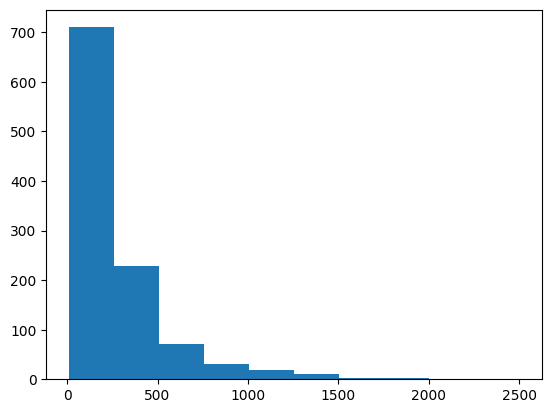

In [293]:
import matplotlib.pyplot 

plt.hist(std_preds_final)
plt.show()

In [294]:
# plt.hist(preds_final)
# plt.show()

In [295]:
preds_denis = pd.read_csv(
    '../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', 
    sep="|", 
    header=None
)

preds_final = data_final[
    ['id_finca', 'variedad','modo','tipo','color','superficie']
].copy()

preds_final['produccion'] = y_pred_final

preds_final = preds_final.sort_values(
    ['id_finca', 'variedad','modo','tipo','color','superficie'], 
    ascending=True
)

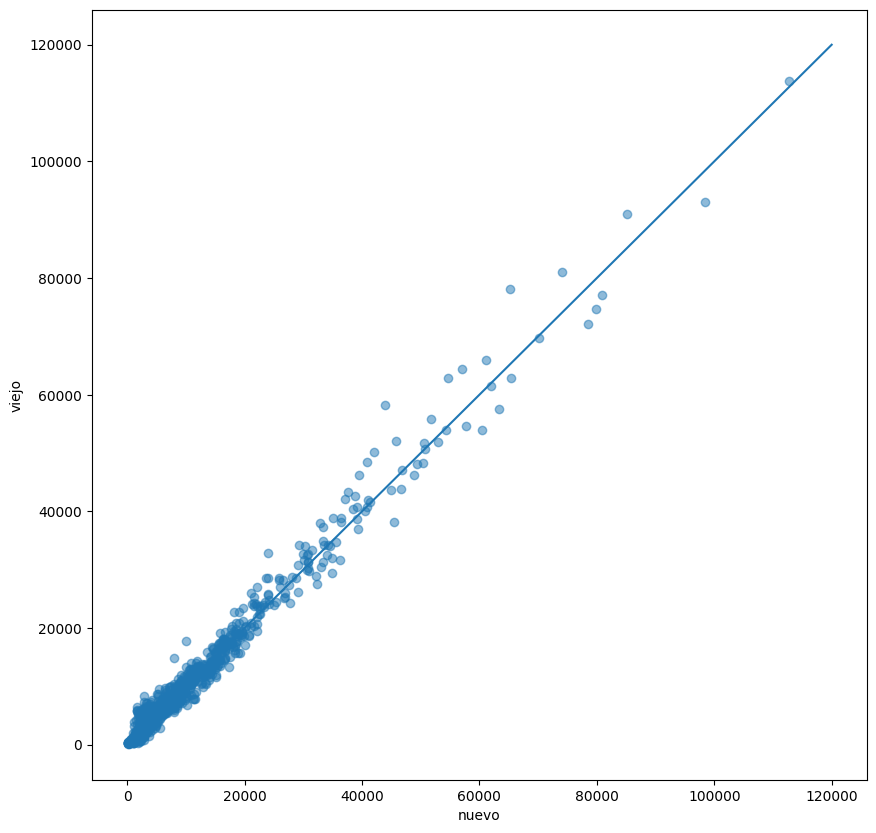

In [296]:
plt.figure(figsize=(10, 10))
plt.scatter(x=preds_final.iloc[:,-1],
            y=preds_denis.iloc[:, -1], alpha=0.5)
plt.plot([0, 120000], [0, 120000])
plt.xlabel('nuevo')
plt.ylabel('viejo')
plt.show()

In [ ]:
# random forest

def build_model():
    model_num_cols = [
#         "campaña",
        'superficie',
#         'prod_he_var_zone_mean_hist',
#         'prod_he_var_zone_std_hist',
#         'prod_he_var_mean_hist',
#         'prod_he_var_std_hist',

        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_est_mean_change',
#         'n_var_camp_finca'
    ]

    model_cat_cols = [
        'id_finca',
        'id_zona',
        "id_estacion",
        'variedad',
        "modo",
#         "tipo",
        "color",
        "prod_shift1_gt_shift2"
    ]
    m = make_pipeline( 
        make_column_transformer(
            (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), model_cat_cols),

            (ce.CatBoostEncoder(),['variedad']),
            (ce.CatBoostEncoder(),['id_zona']),
#             (ce.TargetEncoder(),['variedad']),
#             (ce.CatBoostEncoder(),['id_finca']),
#             (ce.CatBoostEncoder(),['id_estacion']),
#             (ce.BaseNEncoder(),['variedad']),
#             (QuantileFeatureEncoder(col="id_finca"), ['id_finca']),
#             (QuantileFeatureEncoder(col="id_zona"), ['id_zona']),
#             (ThresholdFeatureEncoder(col='altitud'), ['altitud']),
#             (ThresholdFeatureEncoder(col='variedad'), ['variedad']),
            (KBinsDiscretizer(n_bins=3), ['altitud']),
            (MinMaxScaler(), model_num_cols),
            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=3,
            n_jobs=-1,
            max_features='sqrt',
        )
    )
    return m
